# Pythia-410M transcoder-vs.-SAE interpretability challenge!

In [1]:
from transcoder_circuits.circuit_analysis import *
from transcoder_circuits.feature_dashboards import *
from transcoder_circuits.replacement_ctx import *

Now, import the SAE/transcoder code, along with the model that we'll be analyzing (GPT2-small).

In [2]:
from sae_training.sparse_autoencoder import SparseAutoencoder
from transformer_lens import HookedTransformer, utils
import os
import torch

model = HookedTransformer.from_pretrained('pythia-410m')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-410m into HookedTransformer


Now, load in a corpus of text that we'll use for our analysis. We'll be drawing from OpenWebText, which is similar to the dataset on which GPT2-small was trained.

In [3]:
# This function was stolen from one of Neel Nanda's exploratory notebooks
# Thanks, Neel!
import einops
def tokenize_and_concatenate(
    dataset,
    tokenizer,
    streaming = False,
    max_length = 1024,
    column_name = "text",
    add_bos_token = True,
):
    """Helper function to tokenizer and concatenate a dataset of text. This converts the text to tokens, concatenates them (separated by EOS tokens) and then reshapes them into a 2D array of shape (____, sequence_length), dropping the last batch. Tokenizers are much faster if parallelised, so we chop the string into 20, feed it into the tokenizer, in parallel with padding, then remove padding at the end.

    This tokenization is useful for training language models, as it allows us to efficiently train on a large corpus of text of varying lengths (without, eg, a lot of truncation or padding). Further, for models with absolute positional encodings, this avoids privileging early tokens (eg, news articles often begin with CNN, and models may learn to use early positional encodings to predict these)

    Args:
        dataset (Dataset): The dataset to tokenize, assumed to be a HuggingFace text dataset.
        tokenizer (AutoTokenizer): The tokenizer. Assumed to have a bos_token_id and an eos_token_id.
        streaming (bool, optional): Whether the dataset is being streamed. If True, avoids using parallelism. Defaults to False.
        max_length (int, optional): The length of the context window of the sequence. Defaults to 1024.
        column_name (str, optional): The name of the text column in the dataset. Defaults to 'text'.
        add_bos_token (bool, optional): . Defaults to True.

    Returns:
        Dataset: Returns the tokenized dataset, as a dataset of tensors, with a single column called "tokens"

    Note: There is a bug when inputting very small datasets (eg, <1 batch per process) where it just outputs nothing. I'm not super sure why
    """
    for key in dataset.features:
        if key != column_name:
            dataset = dataset.remove_columns(key)

    if tokenizer.pad_token is None:
        # We add a padding token, purely to implement the tokenizer. This will be removed before inputting tokens to the model, so we do not need to increment d_vocab in the model.
        tokenizer.add_special_tokens({"pad_token": "<PAD>"})
    # Define the length to chop things up into - leaving space for a bos_token if required
    if add_bos_token:
        seq_len = max_length - 1
    else:
        seq_len = max_length

    def tokenize_function(examples):
        text = examples[column_name]
        # Concatenate it all into an enormous string, separated by eos_tokens
        full_text = tokenizer.eos_token.join(text)
        # Divide into 20 chunks of ~ equal length
        num_chunks = 20
        chunk_length = (len(full_text) - 1) // num_chunks + 1
        chunks = [
            full_text[i * chunk_length : (i + 1) * chunk_length]
            for i in range(num_chunks)
        ]
        # Tokenize the chunks in parallel. Uses NumPy because HuggingFace map doesn't want tensors returned
        tokens = tokenizer(chunks, return_tensors="np", padding=True)[
            "input_ids"
        ].flatten()
        # Drop padding tokens
        tokens = tokens[tokens != tokenizer.pad_token_id]
        num_tokens = len(tokens)
        num_batches = num_tokens // (seq_len)
        # Drop the final tokens if not enough to make a full sequence
        tokens = tokens[: seq_len * num_batches]
        tokens = einops.rearrange(
            tokens, "(batch seq) -> batch seq", batch=num_batches, seq=seq_len
        )
        if add_bos_token:
            prefix = np.full((num_batches, 1), tokenizer.bos_token_id)
            tokens = np.concatenate([prefix, tokens], axis=1)
        return {"tokens": tokens}

    tokenized_dataset = dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=[column_name],
    )
    #tokenized_dataset.set_format(type="torch", columns=["tokens"])
    return tokenized_dataset


In [4]:
from datasets import load_dataset
from huggingface_hub import HfApi
import numpy as np

dataset = load_dataset('Skylion007/openwebtext', split='train', streaming=True)
dataset = dataset.shuffle(seed=42, buffer_size=10_000)
tokenized_owt = tokenize_and_concatenate(dataset, model.tokenizer, max_length=128, streaming=True)
tokenized_owt = tokenized_owt.shuffle(42)
tokenized_owt = tokenized_owt.take(12800*2)
owt_tokens = np.stack([x['tokens'] for x in tokenized_owt])

In [5]:
owt_tokens_torch = torch.from_numpy(owt_tokens).cuda()

# Load transcoder and SAEs

In [6]:
import pickle

In [7]:
transcoder_template = "pythia-transcoders/lr_0.0002_l1_5.5e-05/szsvunrm/final_sparse_autoencoder_pythia-410m_blocks.15.ln2.hook_normalized_32768"
transcoder = SparseAutoencoder.load_from_pretrained(f"{transcoder_template}.pt").eval()
with open(f"{transcoder_template}_log_feature_sparsity.pt", "rb") as fp:
    tc_sparsity = pickle.load(fp)
tc_freqs = tc_sparsity['freqs']

In [8]:
sae_template = "./pythia-saes/l1_7e-05/olr1w3lx/final_sparse_autoencoder_pythia-410m_blocks.15.ln2.hook_normalized_32768"
sae = SparseAutoencoder.load_from_pretrained(f"{sae_template}.pt").eval()
with open(f"{sae_template}_log_feature_sparsity.pt", "rb") as fp:
    sae_sparsity = pickle.load(fp)
sae_freqs = sae_sparsity['freqs']

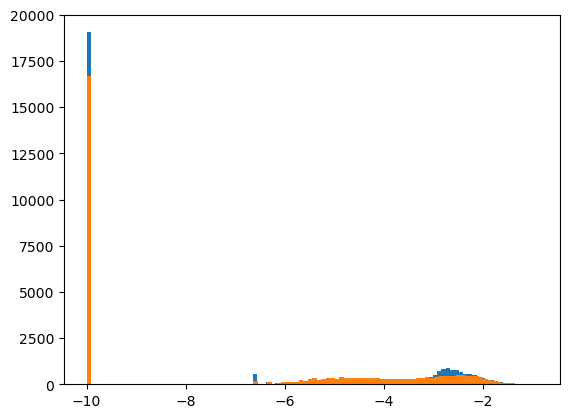

In [9]:
plt.hist(sae_freqs, bins=100)
plt.hist(tc_freqs, bins=100)
plt.show()

In [10]:
tc_live = np.arange(len(tc_freqs))[utils.to_numpy(tc_freqs > -4)]
sae_live = np.arange(len(sae_freqs))[utils.to_numpy(sae_freqs > -4)]

In [11]:
len(sae_live), len(tc_live)

(10403, 9381)

# Generate feature dashboards

This code generates a list of feature dashboards for 50 random transcoder features and 50 random SAE features. It saves these dashboards along with a text file containing the features that they correspond to.

Note that we found that SAE features might have different ranges of activations than transcoder features. To prevent this from coloring our assessment, we then wrote a short additional script (not included here) to remove all numerical information about feature activations from the feature dashboards.

In [21]:
save_dir = 'feature dashboards/'

In [22]:
import random

num_features = 50
tc_features = np.random.choice(tc_live[1:], size=num_features, replace=False)
sae_features = np.random.choice(sae_live[1:], size=num_features, replace=False)
features_list = [(x, 'tc') for x in tc_features] + [(x, 'sae') for x in sae_features]
random.shuffle(features_list)

In [23]:
i = 0
while i < 2*num_features:
    print(f"i: {i}")
    feature_idx, feature_type = features_list[i]
    if feature_type == 'tc':
        scores = get_feature_scores(model, transcoder, owt_tokens_torch, feature_idx, batch_size=128)
    elif feature_type == 'sae':
        scores = get_feature_scores(model, sae, owt_tokens_torch, feature_idx, batch_size=128)
        
    if (scores>0).sum() < 4:
        # replace feature if there are less than four activating examples
        new_feature = None
        while new_feature is None or (new_feature, feature_type) in features_list:
            new_feature = random.choice(tc_live[1:] if feature_type == 'tc' else sae_live[1:])
        del features_list[i]
        features_list.append((new_feature, feature_type))
        continue
    
    with open(save_dir + f'{i}.html', "w") as fp:
        fp.write(display_activating_examples_dash(model, owt_tokens_torch, scores, do_display=False))
    i += 1

with open(save_dir + 'SECRET_FEATURES_LIST.txt', "w") as fp:
    fp.write("\n".join([f'{i}: {feature_type}[{feature_idx}]' for i, (feature_type, feature_idx) in enumerate(features_list)]))

i: 0


100%|██████████| 200/200 [01:54<00:00,  1.75it/s]


i: 1


100%|██████████| 200/200 [01:54<00:00,  1.74it/s]


i: 2


100%|██████████| 200/200 [01:54<00:00,  1.74it/s]


i: 4


100%|██████████| 200/200 [01:54<00:00,  1.75it/s]


i: 5


100%|██████████| 200/200 [01:54<00:00,  1.74it/s]


i: 6


100%|██████████| 200/200 [01:54<00:00,  1.74it/s]


i: 7


100%|██████████| 200/200 [01:54<00:00,  1.74it/s]


i: 8


100%|██████████| 200/200 [01:54<00:00,  1.75it/s]


i: 9


100%|██████████| 200/200 [01:54<00:00,  1.75it/s]


i: 10


 92%|█████████▎| 185/200 [01:46<00:08,  1.74it/s]

KeyboardInterrupt



# Evaluating results

This section shows how we evaluated the results of our interpretability comparison. We load in the list of features and compare them to a list of notes (taken by the human evaluator) for each feature. Then, we can see how many SAE/transcoder features were interpretable, maybe-interpretable, or uninterpretable.

In [1]:
with open('feature dashboards/SECRET_FEATURES_LIST.txt', 'r') as fp:
    feature_strs = fp.readlines()

In [8]:
import numpy as np
is_tc = np.array(['tc' in x for x in feature_strs])
is_sae = np.array(['sae' in x for x in feature_strs])

In [6]:
is_tc.sum()

50

The below cell contains the human evaluator's notes on feature interpretability.

In [9]:
interp_strs = \
"""0 yes
1 yes, context-free
2 yes
3 maybe, context-free
4 yes
5 yes
6 yes
7 yes
8 yes
9 yes
10 yes, context-free
11 maybe
12 maybe
13 yes
14 yes, context-free
15 yes
16 yes
17 yes, context-free
18 yes
19 maybe, context-free
20 yes
21 yes
22 yes
23 yes, context-free
24 maybe, context-free
25 yes, context-free
26 yes
27 yes
28 maybe
29 yes
30 maybe, context-free
31 yes
32 yes
33 maybe
34 yes
35 yes
36 yes
37 yes
38 maybe
39 yes
40 yes
41 yes, context-free
42 no
43 no
44 maybe
45 yes
46 yes
47 yes, context-free
48 yes, context-free
49 yes, context-free
50 yes
51 yes
52 yes
53 yes
54 yes
55 maybe
56 yes
57 no
58 maybe
59 yes
60 yes, context-free
61 yes
62 yes
63 maybe
64 yes
65 no
66 yes
67 maybe
68 yes
69 yes
70 yes
71 yes, context-free
72 maybe
73 yes
74 yes
75 yes, context-free
76 yes
77 yes
78 yes, context-free
79 yes
80 yes
81 yes
82 yes, context-free
83 yes
84 no
85 yes
86 yes, context-free
87 yes
88 yes
89 yes
90 yes
91 yes, context-free
92 yes
93 yes
94 yes
95 yes
96 yes, context-free
97 yes
98 maybe
99 yes""".split("\n")

In [11]:
is_yes = np.array(['yes' in x for x in interp_strs])
is_maybe = np.array(['maybe' in x for x in interp_strs])
is_no = np.array(['no' in x for x in interp_strs])
is_ctx_free = np.array(['context-free' in x for x in interp_strs])

In [13]:
np.logical_and(is_tc, is_yes).sum()

41

In [14]:
np.logical_and(is_sae, is_yes).sum()

38

In [16]:
np.logical_and(is_tc, is_maybe).sum()

8

In [15]:
np.logical_and(is_sae, is_maybe).sum()

8

In [17]:
np.logical_and(is_tc, is_no).sum()

1

In [18]:
np.logical_and(is_sae, is_no).sum()

4

In [19]:
np.logical_and(is_tc, is_ctx_free).sum()

6

In [20]:
np.logical_and(is_sae, is_ctx_free).sum()

16